**Title:** Fraud Detection on Credit Card records using Random Forest.   
**Author:** German Martinez-Ayuso   

**A not very formal, neither comprehensive guide to the application of the gradient boosted decision trees to the detection of fraud in finance.** 

# Decision tree

A decision tree is decision tool whose structure resemble a tree. Each of the nodes of this structure represents a "test" (or evaluation of an activation function). Using the results of these test, the classification rules are obtained which goes from the root (input) to the leaves (outputs). 

One example of decision tree is the Galton machine:

|![Galton machine](galton_machine.gif)| 
|:------:|
|   [Galton machine](https://en.wikipedia.org/wiki/File:Galton_box.webm) |
|From [Wikipedia-Beam machine](https://en.wikipedia.org/wiki/Bean_machine)  |

Each of the pegs is a test where the ball will be driven to one of the sides. Since all the pegs and balls are equal, the probability of the ball going to one side or another is the same. Since it is the same, the balls will tend to be closer to the center because the probability of them going to the extremes is lower. This machine generate a distribution of the balls which corresponds to the "**normal distribution**". 



| ![Galton board](galton_board.png) | 
|:------:|
|   Galton representation  |
| Copyright : Peter Hermes Furian. [123RF.com](https://www.123rf.com/photo_79407706_stock-vector-the-mathematics-of-the-galton-board-with-normal-distribution-and-gaussian-bell-curve-also-quincunx-b.html) |

The decision trees present several advantages. The main one is that they are easy to understand and interpret hence these models are widely applied in order to obtain a good understanding of the underlying model.


## Decision Tree Structure
The decision trees are composed of:
- Nodes. Where the branches growth from. Here is where the tests are applied.
- Branches. They represents the links between nodes.
- Leaves. They are the final output at the end of the branches. They might not be applied any tests. 



# Gradient Boosted Decision Trees


The XGBoost is the solution for the optimization of assemblies of decision trees. It is based on the concept that decision trees can be considered as a function which can be optimized using gradient techniques as any common function. 
This optimization would be "measured" using a loss function. 
This function is a measure of the error in the predicted values compared with the real values in the training set.

The algorithm follows for the next inputs:
- Training set: $\{(x_i, y_i)\}^n_{i=1}$ 
- Differentiable loss function: $L(y,F(x))$ 
- Maximum number of iterations: $M$

the next steps:

1. Initialize the model with random values.

$$F_0(x) = \arg \min \sum^n_{i=1} L(y_i, \gamma)$$

2. For m=1 to M:  

    2.1. Compute so-called pseudo-residuals:
    $$ r_{im} = - \left[ \dfrac{\partial L(y_i,F(x_i))}{\partial F(x_i)} \right]_{F(x) = F_{m-1}(x)} \hspace{3ex} \text{for i = 1,  ..., n}$$   
    
    2.2. Fit a base learner (or weak learner e.g. tree) $h_m(x)$ to pseudo-residuals, i.e. train it using the training set.     
    
    2.3. Compute multiplier $\gamma_m$ by solving the one-dimensional optimization problem:
    $$ \gamma_m = \arg \min \sum^n_{i=1} L(y_i, F_{m-1}(x_i) + \gamma h_m(x_i))$$   
    
    2.4. Update the model:
    $$ F_m(x) = F_{m-1}(x) + \gamma_m h_m(x)$$

3. Output $F_M(x)$.

This is as it is explained in Wikipedia. However in a more simplistic way, this procedure could be explained as:

1. Initialize the model with random values ($x_0$).
2. Start iterations until maximum number of iterations is reached. 

    2.1. Calculate the increments in the loss function for the values ($x_m$).  
    2.2. Train the decision trees ($h_m(x)$) to fit the increments.  
    2.3. Obtain $\gamma$ from the optimization problem given the trained trees.  
    2.4. Update the model ($F_m(x)$).   
    
It should be noticed that the decision trees are trained on the residual, hence their results $h_m(x)$ are added to the solution in the previous iteration $F_{m-1}(x)$ multiplied by $\gamma_m$. 


## Avoiding overfitting.

Overfitting is the what happens when the model tends to replicate very accurate the training set but it does not perform well on new data. 
This is considered as a reduction in the generality of the model and it is addressed by using regularization techniques:

### Shrinkage
This consists in adding another multiplier to the $\gamma_m$ coefficient:  
$$ F_m(x) = F_{m-1}(x) + \nu \gamma_m h_m(x)  \hspace{3ex} 0 < \nu \leq 1$$   
where $\nu$ is called "learning rate". 

This improves substantially the performance the model. Empirically it is demonstrated that values of $\nu$ lower than 0.1 are the best. 


### Stochastic gradient boosting

Stochastic gradient boosting take the idea from the bootstrap aggregation ("bagging") method. 
The idea consists on train each of the trees ($h_m(x)$) in a subset of the training set randomly generated without replacement.
It has been observed that this improve substantially the model accuracy. 
The subsample size is represented as a fraction $f$ of the total set. If $f=1$ this improvement is not applied. Practically it has been observed that for moderate or small size dataset, the optimal $f$ values are between 0.5 and 0.8.
Since the subsets are smaller, there is generally an improvement in the training speed. 

This approach might leave out some observations when building the learners (trees). These observation can be used as a validation inside the scheme hence it is not needed a validation set. The error between these leave-out observations and the model predictions is called "out-of-bag error. 


### Number of observation in leaves.
Ensuring that there is, at least, a minimum number of observations in each of the leaves of the trees is another way to help to regularize the model. 


### Penalize tree complexity
The complexity of the tree is measured as the number of leaves. Using a suitable pruning approach it might help to reduce the number of leaves by removing leaves or branches that do not contribute to reduce the loss by a threshold. 


--  
Reference: [Wikipedia-Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting)

# Application of XGBoost to Finance Fraud detection

## Dataset: Credit card transfers.

Importing libraries

In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Reading the data 

In [2]:
df = pd.read_csv("creditcard.csv")

print(df.columns)
df.head()

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The variables are not defined, then we are going to use a black-input approach. We won't do an exploratory analysis. 


## Model application

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
# Splitting the dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                    df.drop('Class',axis=1),
                                    df['Class'],
                                    test_size=0.3,
                                    train_size=0.7,
                                    random_state=1)

In [5]:
from sklearn.metrics import roc_auc_score as measure_roc_auc
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [6]:
xgb = XGBClassifier(max_bin=16)

# Space search for the parameters.
prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2], #Step size shrinkage used to prevent overfitting. Range is [0,1]
    'n_estimators':[100,200,500,1000,2000],        #Number of trees you want to build.
    'max_depth':[3,5,10],                          #The maximum depth of a tree
    'colsample_bytree':[0.1,0.3,0.5,1],            #Denotes the fraction of columns to be randomly samples for each tree.
    'subsample':[0.1,0.3,0.5,1]                    #Denotes the fraction of observations to be randomly samples for each tree.
}

prams={
    'learning_rate':[0.05], #Step size shrinkage used to prevent overfitting. Range is [0,1]
    'n_estimators':[100],        #Number of trees you want to build.
    'max_depth':[3],                          #The maximum depth of a tree
    'colsample_bytree':[0.1],            #Denotes the fraction of columns to be randomly samples for each tree.
    'subsample':[0.1]                    #Denotes the fraction of observations to be randomly samples for each tree.
}


#RandomizedSearchCV search for the optimal set of hyperparameters
opt_xgb=RandomizedSearchCV(xgb,
                              param_distributions=prams,
                              verbose=2,
                              n_iter=20,
                              cv=10,
                              scoring='roc_auc',
                              n_jobs=2 # To speed up calculations
                             );

opt_xgb.fit(X_train, y_train) #Training

pprint(opt_xgb.best_params_)
print("\nThe AUC score is {}".format(opt_xgb.best_score_))

C:\ProgramData\Miniconda3\envs\keras\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  1.6min finished


{'colsample_bytree': 0.1,
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 0.1}

The AUC score is 0.9612704724230839


In [7]:
# Saving
%store opt_xgb df 
# backup = pd.HDFStore('backup.h5')
# backup['df'] = df
# backup['opt_xgb'] = opt_xgb
# backup.close()

#load 
# %store -r opt_xgb df 
# backup = pd.HDFStore('backup.h5')
# df = backup['df']
# opt_xgb = backup['opt_xgb']

Stored 'opt_xgb' (RandomizedSearchCV)
Stored 'df' (DataFrame)


Evaluating


In [8]:
predict_y = opt_xgb.predict_proba(X_test)
accur_training = measure_roc_auc(y_test, predict_y[:, 1])

print("The test AUC for training data is: {:0.6f}".format(accur_training))

The test AUC for training data is: 0.962289


The AUC score is 0.962289 on the test samples. The AUC score is the area under the curve ROC which is the 

In [9]:
from sklearn.metrics import roc_curve, auc
i=1

y_test.values

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [11]:

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()

# fpr, tpr, _ = roc_curve(y_test, predict_y[:, 1])
# roc_auc = auc(fpr, tpr)


# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), predict_y.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# # Plot of a ROC curve for a specific class
# plt.figure()
# lw = 2
# plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])

# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()


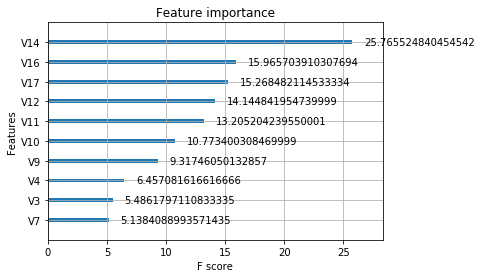

In [12]:
from xgboost import plot_importance
from xgboost import plot_tree

model = opt_xgb.best_estimator_
 
plot_importance(model, importance_type='gain', max_num_features=10); 